In [1]:
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import numpy.linalg
from skimage import img_as_float
import os

cwd = os.getcwd()

## Import Dataset

In [2]:
x = scipy.io.loadmat(os.path.join(cwd, "facedata.mat"))

In [3]:
img_width = x['facedata'][0,0].shape[1]
img_height = x['facedata'][0,0].shape[0]

person = x['facedata'].shape[0]

print("Datas:", x['facedata'].shape)
print("Image Size:", x['facedata'][0,0].shape)

Datas: (40, 10)
Image Size: (56, 46)


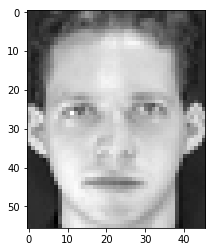

In [4]:
plt.imshow(x['facedata'][0,0],cmap="gray")
plt.show()

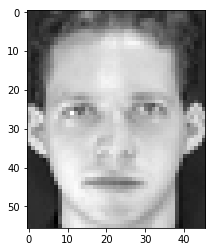

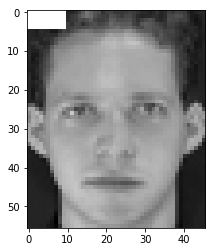

In [6]:
def plot_image(x):
    plt.imshow(x, cmap="gray")
    plt.show()

xf = {}
for i in range(x['facedata'].shape[0]):
    for j in range(x['facedata'].shape[1]):
        xf[i,j] = img_as_float(x['facedata'][i,j])
    
plot_image(xf[0,0])
plt.show()

x_temp = xf[0,0].copy()
x_temp[0:5,0:10] = 1

# In float format, 1 is white
plot_image(x_temp)

## Similarity

In [7]:
def distance(x, y):
    return np.sqrt(np.sum((x - y)**2))

Find similarity of (0,0), (1,0) and (0,1)

In [8]:
print(distance(xf[0,0], xf[0,1]))
print(distance(xf[0,0], xf[1,0]))

10.0376162942
8.17329509974


In [9]:
def create_similar_matrix(list_x, list_y, img):
    mt = np.zeros((len(list_y), len(list_x)))
    for i, t in enumerate(list_y):
        for j, d in enumerate(list_x):
            mt[i,j] = distance(img[t[0],t[1]],img[d[0],d[1]])
    
    return mt

def plot_matrix(mt):
    plt.imshow(mt / mt.max(), cmap='gray')
    plt.show()

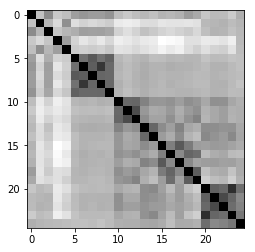

In [10]:
first_5 = []

for i in range(5):
    for j in range(5):
        first_5.append([i,j])

matrix = create_similar_matrix(first_5, first_5, xf)
plot_matrix(matrix)

Create similar matrix with D and T data

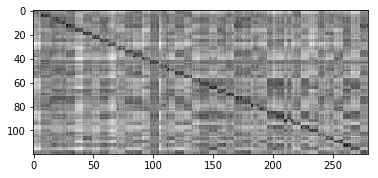

In [11]:
D = []
T = []

for i in range(40):
    for j in range(3):
        T.append([i,j])
    for j in range(3,10):
        D.append([i,j])

matrix = create_similar_matrix(D, T, xf)
plot_matrix(matrix)

## Simple Verfication

In [12]:
def simple_verification(ths):
    tp = fp = tn = fn = 0
    for i in np.arange(0, matrix.shape[0], 3):
        for j in range(matrix.shape[1]):
            d = D[j]
            t = T[i]
            
            is_same = False
            if matrix[i][j] < ths or matrix[i+1][j] < ths or matrix[i+2][j] < ths:
                is_same = True
            
            if d[0] == t[0]:
                if is_same == True:
                    tp += 1
                else:
                    fn += 1
            else:
                if is_same == False:
                    tn += 1
                else:
                    fp += 1
            
    return [tp, fp, fn, tn]

In [13]:
tp, fp, fn, tn = simple_verification(np.sqrt(140))
print("True positive rate: ", tp / (tp + fn + 1e-18))
print("False alarm rate:", fp / (fp + tn + 1e-18))

True positive rate:  1.0
False alarm rate: 0.819047619047619


* Calculate RoC and plot graph
* Find EER using interpolation between two points

In [14]:
def find_cross_point(x_1, y_a_1, y_a_2, x_2, y_b_1, y_b_2):
    m_a = (y_a_2 - y_a_1) / (x_2 - x_1)
    m_b = (y_b_2 - y_b_1) / (x_2 - x_1)

    b_a = y_a_2 - m_a * x_2
    b_b = y_b_2 - m_b * x_2

    x_c = (b_a - b_b) / (m_b - m_a)
    
    return [x_c, m_a * x_c + b_a]

def roc_hist(matrix, space_size = 1000):
    tpr = []
    far = []
    ths = []
    min_ths = np.min(matrix)
    max_ths = np.max(matrix)
    for t in np.arange(min_ths, max_ths, (max_ths - min_ths) / space_size):
        tp, fp, fn, tn = simple_verification(t)
        tpr.append(tp / (tp + fn + 1e-18))
        far.append(fp / (fp + tn + 1e-18))
        ths.append(t)
        
    for i in range(len(tpr)):
        diff = (1 - tpr[i]) - far[i]
        if diff < 0:
            y_a_1 = (1 - tpr[i - 1])
            y_a_2 = (1 - tpr[i])
            y_b_1 = far[i - 1]
            y_b_2 = far[i]
            x_1 = ths[i - 1]
            x_2 = ths[i]
            
            eer_ths, eer = find_cross_point(x_1, y_a_1, y_a_2, x_2, y_b_1, y_b_2)
            break
    
    return [tpr, far, eer, eer_ths]

def plot_roc(tpr, far):
    plt.plot(far, tpr)
    plt.ylabel('TPR')
    plt.xlabel('FAR')
    plt.show()

In [15]:
tpr, far, eer, eer_ths = roc_hist(matrix)
tpr_base = tpr
far_base = far

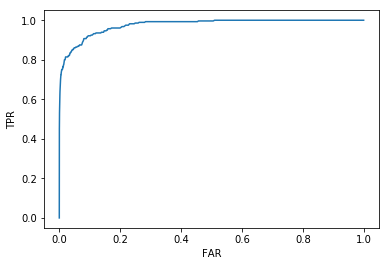

EER: 0.0891053391053
EER threshold: 8.08599822073


In [16]:
plot_roc(tpr, far)
print("EER: " + str(eer))
print("EER threshold: " + str(eer_ths))

In [17]:
def calculate_recall_from_far(tpr, far, far_th):
    for i in range(len(tpr)):
        if far[i] > far_th:
            itp = (far_th - far[i - 1]) / (far[i] - far[i - 1])
            recall = itp * (tpr[i] - tpr[i - 1]) + tpr[i - 1]
            print("Recall " + str(recall) + " at False alarm rate " + str(far_th))
            break

calculate_recall_from_far(tpr, far, 0.001)

Recall 0.546142857142857 at False alarm rate 0.001


## PCA

In [18]:
x_face = None

for t in T:
    if x_face is None:
        x_face = xf[t[0], t[1]][np.newaxis, ...]
    else:
        x_face = np.append(x_face, xf[t[0], t[1]][np.newaxis, ...], axis=0)

Find average X and subtract from X

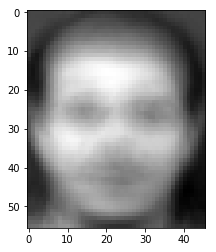

In [19]:
x_average = np.average(x_face, axis=0)
plot_image(x_average)

In [20]:
x_face -= x_average

Reshape data

In [21]:
x_face_flat = x_face.reshape((x_face.shape[0], -1)).T
x_face_flat.shape

(2576, 120)

In [22]:
eig_val, eig_vec = numpy.linalg.eigh(np.matmul(x_face_flat.T, x_face_flat))

Sort eigenvalues

In [23]:
eig_val = eig_val[::-1]
eig_vec = np.fliplr(eig_vec)

In [24]:
eig_val[0:20]

array([ 1423.92971484,   875.37517697,   558.62440028,   407.34715673,
         371.02127373,   263.28080075,   203.39698967,   190.96510133,
         166.54805607,   143.5705511 ,   122.9512005 ,   104.78822858,
          93.66069926,    85.20209342,    80.0790884 ,    72.29262697,
          69.28960161,    65.55579139,    61.67912591,    59.07435533])

How many non-zero eigenvectors

In [25]:
n_select_eigen = len(eig_val[eig_val > 1e-12])
print("Nonzero (Ignore small number): ", n_select_eigen)

Nonzero (Ignore small number):  119


Plot eigenvalues in descending order

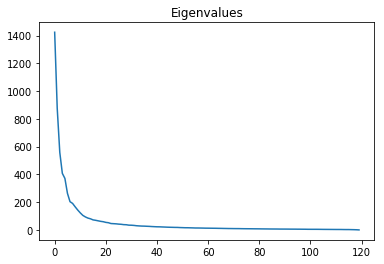

In [26]:
plt.plot(eig_val)
plt.title("Eigenvalues")
plt.show()

Number of eigenvectors that keep 95% data

In [27]:
def find_eigen_cover_95(eig_val):
    var = np.sum(eig_val) * .95
    cur_var = 0
    n = 0
    for i in range(len(eig_val)):
        cur_var += eig_val[i]
        if cur_var > var:
            n = i + 1
            print("Number of used eigens: " + str(n))
            break
    return n

n_eigens = find_eigen_cover_95(eig_val)

Number of used eigens: 64


Calculate `v_vec = X v_vec'`

In [28]:
v_vec = np.matmul(x_face_flat, eig_vec)
v_vec /= numpy.linalg.norm(v_vec, axis=0)
pca_vec = v_vec

Plot 10 eigenvectors

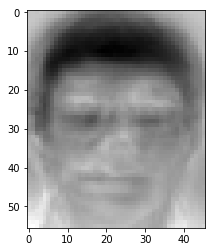

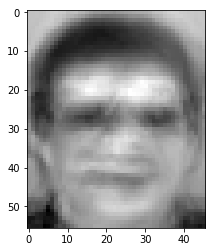

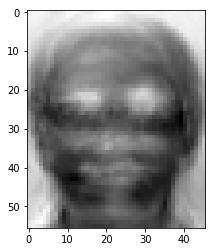

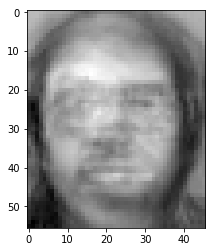

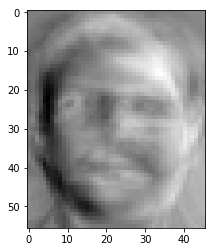

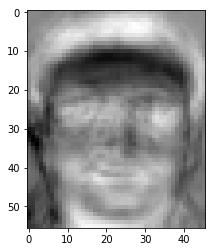

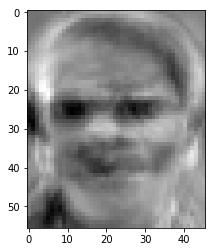

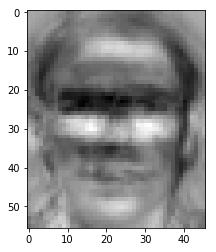

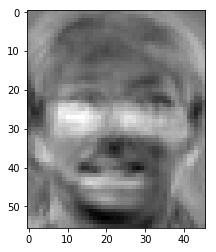

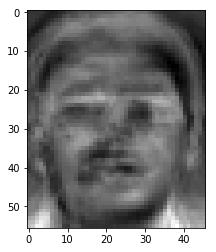

In [29]:
for i in range(0, 10):
     plot_image(1 - v_vec.T[i].reshape(img_height, img_width))

## PCA and Face verification

Projection on `k=10`

In [30]:
def init_project(k):
    project = {}
    for i in range(x['facedata'].shape[0]):
        for j in range(x['facedata'].shape[1]):
            project[i,j] = np.matmul(v_vec.T[0:k], (xf[i,j] - x_average).reshape(img_height * img_width))
    return project

project = init_project(10)

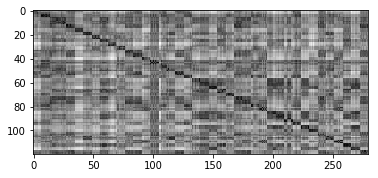

In [31]:
matrix = create_similar_matrix(D, T, project)
plot_matrix(matrix)

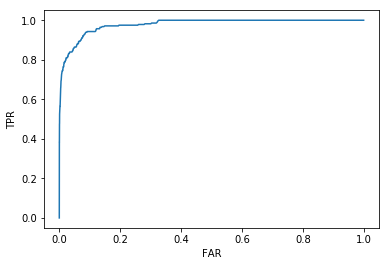

EER: 0.0785714285714
EER threshold: 4.78487988508
Recall 0.5141428571428571 at False alarm rate 0.001


In [32]:
tpr, far, eer, eer_ths = roc_hist(matrix)
plot_roc(tpr, far)
print("EER: " + str(eer))
print("EER threshold: " + str(eer_ths))
calculate_recall_from_far(tpr, far, 0.001)

Projection on `k = 5, 6, 7, 8, 9, 10, 11, 12, 13, 14`

In [33]:
for k in range(5,15):
    print("K = " + str(k))
    project = init_project(k)
    matrix = create_similar_matrix(D, T, project)
    tpr, far, eer, eer_ths = roc_hist(matrix)
    
    print("EER: " + str(eer))
    print("EER theshold: " + str(eer_ths))
    calculate_recall_from_far(tpr, far, 0.001)
    
    print("=============")

K = 5
EER: 0.107142857143
EER theshold: 3.70790491071
Recall 0.25357142857142856 at False alarm rate 0.001
K = 6
EER: 0.0937317784257
EER theshold: 3.98945069545
Recall 0.34585714285714286 at False alarm rate 0.001
K = 7
EER: 0.0928571428571
EER theshold: 4.29326000467
Recall 0.4104285714285714 at False alarm rate 0.001
K = 8
EER: 0.0857142857143
EER theshold: 4.49524460482
Recall 0.40714285714285714 at False alarm rate 0.001
K = 9
EER: 0.0804209183673
EER theshold: 4.63769630817
Recall 0.4516428571428571 at False alarm rate 0.001
K = 10
EER: 0.0785714285714
EER theshold: 4.78487988508
Recall 0.5141428571428571 at False alarm rate 0.001
K = 11
EER: 0.0779974489796
EER theshold: 4.96911039968
Recall 0.5035714285714286 at False alarm rate 0.001
K = 12
EER: 0.0855685131195
EER theshold: 5.19106965554
Recall 0.5101428571428571 at False alarm rate 0.001
K = 13
EER: 0.081954887218
EER theshold: 5.25074211878
Recall 0.5175714285714286 at False alarm rate 0.001
K = 14
EER: 0.0821428571429
EER 

In [34]:
project = init_project(13)
matrix = create_similar_matrix(D, T, project)
tpr, far, eer, eer_ths = roc_hist(matrix)

print("EER: " + str(eer))
print("EER theshold: " + str(eer_ths))
calculate_recall_from_far(tpr, far, 0.001)

tpr_pca = tpr
far_pca = far

EER: 0.081954887218
EER theshold: 5.25074211878
Recall 0.5175714285714286 at False alarm rate 0.001


## LDA

In [35]:
K = 80
x_p = init_project(K)

In [36]:
def transform_dict_to_array(dic):
    xs = []
    for p in range(x['facedata'].shape[0]):
        xp = [dic[p,i] for i in range(3)]
        xs.append(xp)
    return xs

x_tr = transform_dict_to_array(x_p)

In [37]:
x_tr = np.array(x_tr)
u_tr = np.average(x_tr, axis=1)
u_tr_all = np.average(x_tr, axis=(0,1))

In [ ]:
S_b = np.zeros((K,K))
for p in range(person):
    result = np.matmul(np.matrix(u_tr[p] - u_tr_all).T, np.matrix(u_tr[p] - u_tr_all))
    S_b += result

In [ ]:
S_w = np.zeros((K,K))
for p in range(person):
    xs = x_tr.reshape((person * 3, -1))
    for i in range(xs.shape[0]):
        S_w += np.matmul(np.matrix(xs[i] - u_tr[p]).T, np.matrix(xs[i] - u_tr[p]))

In [40]:
eig_val, eig_vec = numpy.linalg.eigh(np.matmul(numpy.linalg.inv(S_w), S_b))
eig_val = eig_val[::-1]
eig_vec = np.fliplr(eig_vec)
eig_vec /= numpy.linalg.norm(eig_vec, axis=0)
lda_vec = eig_vec

Find non-zero eigenvalues

In [41]:
neg = len(eig_val[eig_val > 1e-12])
n_lda_vec = K - neg
print("Zero & Negative eigenvalues: ", neg)

Zero & Negative eigenvalues:  39


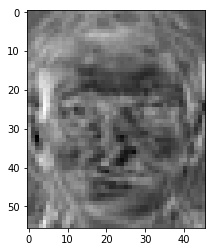

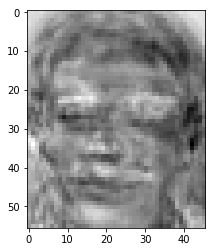

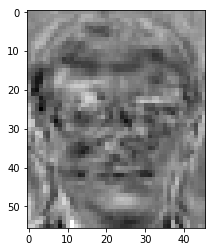

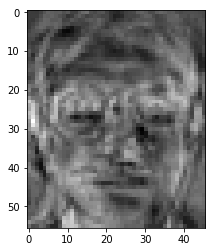

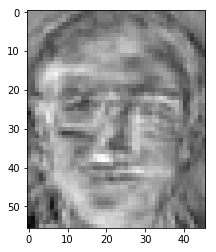

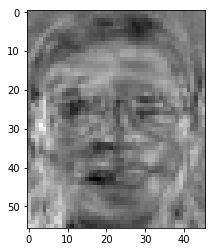

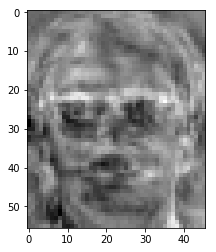

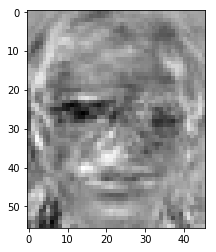

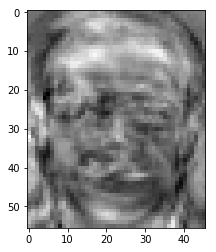

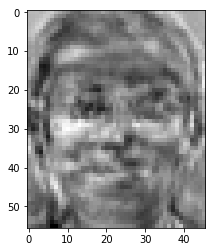

In [42]:
for i in range(0, 10):
    eigenface = np.matmul(pca_vec[:,0:K], lda_vec[:,i])
    plot_image(eigenface.reshape(img_height, img_width))

In [43]:
def init_project_lda():
    project = {}
    for i in range(x['facedata'].shape[0]):
        for j in range(x['facedata'].shape[1]):
            project[i,j] = np.matmul(
                np.matmul(lda_vec[:,0:n_lda_vec], pca_vec.T[0:n_lda_vec]), 
                (xf[i,j] - x_average).reshape(img_height * img_width)
            )
    return project

In [44]:
project = init_project_lda()

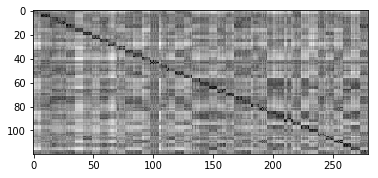

In [45]:
matrix = create_similar_matrix(D, T, project)
plot_matrix(matrix)

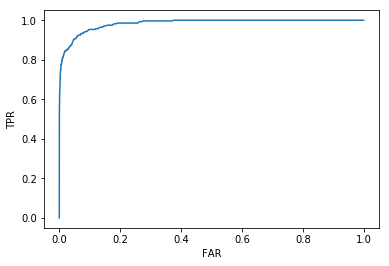

EER: 0.0701086956522
EER threshold: 6.46239922393
Recall 0.5854285714285714 at False alarm rate 0.001


In [46]:
tpr, far, eer, eer_ths = roc_hist(matrix)
plot_roc(tpr, far)
print("EER: " + str(eer))
print("EER threshold: " + str(eer_ths))
calculate_recall_from_far(tpr, far, 0.001)

In [47]:
tpr_lda = tpr
far_lda = far

## Plot three graph

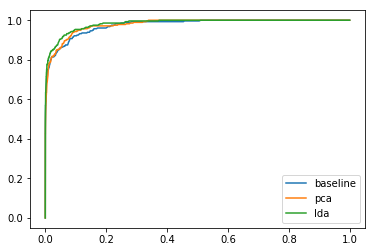

In [48]:
plt.plot(far_base, tpr_base, label='baseline')
plt.plot(far_pca, tpr_pca, label='pca')
plt.plot(far_lda, tpr_lda, label='lda')
plt.legend(['baseline','pca','lda'])
plt.show()